<h2>This notebook when run will produce a module which predicts the chance of death of patients in ICU after 24 hours</h2>

Importing libraries

In [3]:
import time

# visualizatoin 
import matplotlib.pyplot as plt 

# data wrangling
import pandas as pd
import numpy as np 

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from imblearn.over_sampling import SMOTE

#learning
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb


#post-processing
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

Loading data

In [4]:
# description
description = pd.read_csv('data/WiDS_Datathon_2020_Dictionary.csv')
description_dict = description.set_index('Variable Name').to_dict(orient='index')
# data
df = pd.read_csv('data/training_v2.csv')

df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


<h3>Pre-processing</h3>

In [5]:
test_size = 0.2 # proportion for train versus test+val split
val_size = 0.5 # proportion for test versus valsplit
random_state = 42  # random state is used to set a seed for randomness, which is only relevant for reproducibility purposes
max_missing = 0.8  # maximum percentage of missing values for a column to be dropped

In [6]:
start_time = time.time()

# save features
X = df.copy().drop(['hospital_death', 'patient_id', 'encounter_id', 'hospital_id', 'icu_id', # drop identifiers
                    'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', # drop APACHE scores
                    'apache_2_bodysystem', 'bmi'], # drop because of similarity with apache_3j_bodysystem
                   axis=1)
# save target variable
y = df['hospital_death'].copy()
# save APACHE scores for later evaluation on train / test / validation data
y_apache = df['apache_4a_hospital_death_prob'].copy()

""" SPLIT DATA SET """
# split the dataset into train and test+validation set
(
    X_train,
    X_test,
    y_train,
    y_test,
    y_apache_train,
    y_apache_test,
    ) = train_test_split(X, y, y_apache, 
                         test_size=test_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 
# split the test set into test + validation set
(
    X_val,
    X_test,
    y_val,
    y_test,
    y_apache_val,
    y_apache_test,
    ) = train_test_split(X_test, y_test, y_apache_test, 
                         test_size=val_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 

# """MISSING VALUES"""
# # drop columns with many missing values
# missing = X_train.isna().sum() > max_missing * len(X_train)
# missing = missing[missing].index
# X_train = X_train.drop(missing, axis=1)
# X_val = X_val.drop(missing, axis=1)
# X_test = X_test.drop(missing, axis=1)

"""FURTHER PROCESSING PIPELINE"""
# define pre-processing steps for numerical features
num_transformer = Pipeline(steps=[("constant", VarianceThreshold()), # remove constant features
                                  ("imputer", SimpleImputer(strategy="median")),
                                 ])
# define preprocessing steps for categorical features
cat_transformer = Pipeline(steps=[("encoder", OneHotEncoder(drop='first', sparse=False, handle_unknown="ignore"))])
# create preprocessing pipeline
prep_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_transformer, make_column_selector(dtype_exclude=object)), # apply to columns NOT of type object (int or float)
        ('cat', cat_transformer, make_column_selector(dtype_include=object)) # apply to columns of type object
    ])
# pipeline
prep_pipeline.fit(X_train, y_train)
display(prep_pipeline) # disply preprocessing pipeline

# transform data sets
X_train = pd.DataFrame(prep_pipeline.transform(X_train), columns=prep_pipeline.get_feature_names_out())
X_val = pd.DataFrame(prep_pipeline.transform(X_val), columns=prep_pipeline.get_feature_names_out())
X_test = pd.DataFrame(prep_pipeline.transform(X_test), columns=prep_pipeline.get_feature_names_out())
        
"""PRINT STATS"""
print("Time: %.2fs" % (time.time() - start_time))
print("Train set: %s rows, %s columns" % X_train.shape)
print("Validation set: %s rows, %s columns" % X_val.shape)
print("Test set: %s rows, %s columns" % X_test.shape)

c:\Users\20200642\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('constant',
                                                  VarianceThreshold()),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001ACE9EE3D60>),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001ACE9EE3DC0>)])

Time: 3.60s
Train set: 73370 rows, 217 columns
Validation set: 9171 rows, 217 columns
Test set: 9172 rows, 217 columns


In [7]:


sm = SMOTE(sampling_strategy='minority', random_state=42)
oversampled_X, oversampled_Y = sm.fit_resample(X_train, y_train)

Adding a cross-validation method (Modified from [author here])

In [8]:
# K-Fold Cross-Validation
#taken from https://www.section.io/engineering-education/how-to-implement-k-fold-cross-validation/
from sklearn.model_selection import cross_validate

def cross_validation(model, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'roc_auc', 'f1', 'recall']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training AUC scores": results['train_roc_auc'],
              "Mean Training AUC score": results['train_roc_auc'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation AUC Scores": results['test_roc_auc'],
              "Mean Validation AUC score": results['test_roc_auc'].mean(),
              "Validation f1 Scores": results['test_f1'],
              "Mean Validation f1 score": results['test_f1'].mean(),
              "Validation recall Scores": results['test_recall'],
              "Mean Validation recall score": results['test_recall'].mean()
              }

Implementation of the model

In [9]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", booster='gbtree', eval_metric=['logloss', 'auc'], n_estimators=5000, early_stopping_rounds=50)

In [13]:
eval_set=[(X_val, y_val)]
xgb_model.fit(
    oversampled_X, oversampled_Y,
    eval_set=eval_set,
    verbose=True
)

[0]	validation_0-logloss:0.55036	validation_0-auc:0.79543
[1]	validation_0-logloss:0.46382	validation_0-auc:0.81848
[2]	validation_0-logloss:0.40877	validation_0-auc:0.83063
[3]	validation_0-logloss:0.37115	validation_0-auc:0.83826
[4]	validation_0-logloss:0.33814	validation_0-auc:0.84390
[5]	validation_0-logloss:0.31050	validation_0-auc:0.84640
[6]	validation_0-logloss:0.29227	validation_0-auc:0.85055
[7]	validation_0-logloss:0.27425	validation_0-auc:0.85483
[8]	validation_0-logloss:0.25919	validation_0-auc:0.85874
[9]	validation_0-logloss:0.25086	validation_0-auc:0.86121
[10]	validation_0-logloss:0.24230	validation_0-auc:0.86307
[11]	validation_0-logloss:0.23577	validation_0-auc:0.86592
[12]	validation_0-logloss:0.23028	validation_0-auc:0.86839
[13]	validation_0-logloss:0.22766	validation_0-auc:0.86805
[14]	validation_0-logloss:0.22281	validation_0-auc:0.87069
[15]	validation_0-logloss:0.22066	validation_0-auc:0.87214
[16]	validation_0-logloss:0.21798	validation_0-auc:0.87342
[17]	va

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=['logloss', 'auc'],
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=5000, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

Class imbalance demonstration with F1 and recall scores

In [15]:
cross_validation(xgb_model, X_train, y_train)

{'Training Accuracy scores': array([0.97485348, 0.97638681, 0.97439349, 0.97471719, 0.97459793]),
 'Mean Training Accuracy': 97.49897778383536,
 'Training AUC scores': array([0.98864183, 0.98881347, 0.98733322, 0.98739874, 0.98769333]),
 'Mean Training AUC score': 0.9879761163450758,
 'Validation Accuracy scores': array([0.92817228, 0.92980782, 0.92701377, 0.93096634, 0.93096634]),
 'Mean Validation Accuracy': 92.93853073463268,
 'Validation AUC Scores': array([0.88464715, 0.88506151, 0.89041186, 0.89657592, 0.89668832]),
 'Mean Validation AUC score': 0.8906769492755993,
 'Validation f1 Scores': array([0.45837616, 0.46073298, 0.45048743, 0.47540135, 0.48077909]),
 'Mean Validation f1 score': 0.46515540081241047,
 'Validation recall Scores': array([0.35256917, 0.34782609, 0.34676145, 0.36255924, 0.37045814]),
 'Mean Validation recall score': 0.3560348175761322}

Class imblance fix with SMOTE (oversampling minority classes using KNN)

Post-processing basic explainations only for 1 run of CV

[0]	validation_0-logloss:0.55036	validation_0-auc:0.79543
[1]	validation_0-logloss:0.46382	validation_0-auc:0.81848
[2]	validation_0-logloss:0.40877	validation_0-auc:0.83063
[3]	validation_0-logloss:0.37115	validation_0-auc:0.83826
[4]	validation_0-logloss:0.33814	validation_0-auc:0.84390
[5]	validation_0-logloss:0.31050	validation_0-auc:0.84640
[6]	validation_0-logloss:0.29227	validation_0-auc:0.85055
[7]	validation_0-logloss:0.27425	validation_0-auc:0.85483
[8]	validation_0-logloss:0.25919	validation_0-auc:0.85874
[9]	validation_0-logloss:0.25086	validation_0-auc:0.86121
[10]	validation_0-logloss:0.24230	validation_0-auc:0.86307
[11]	validation_0-logloss:0.23577	validation_0-auc:0.86592
[12]	validation_0-logloss:0.23028	validation_0-auc:0.86839
[13]	validation_0-logloss:0.22766	validation_0-auc:0.86805
[14]	validation_0-logloss:0.22281	validation_0-auc:0.87069
[15]	validation_0-logloss:0.22066	validation_0-auc:0.87214
[16]	validation_0-logloss:0.21798	validation_0-auc:0.87342
[17]	va

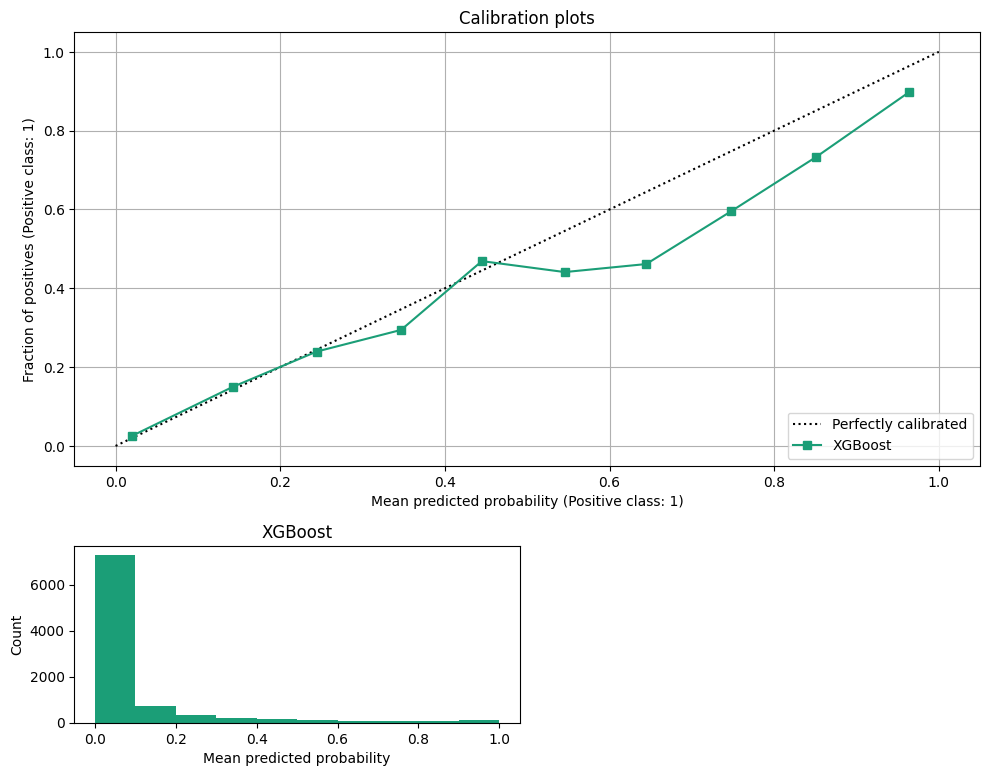

In [15]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

clf_list = [
    (xgb_model, "XGBoost")
]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
eval_set=[(X_val, y_val)]
for i, (clf, name) in enumerate(clf_list):
    clf.fit(oversampled_X, oversampled_Y,eval_set=eval_set)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_val,
        y_val,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()


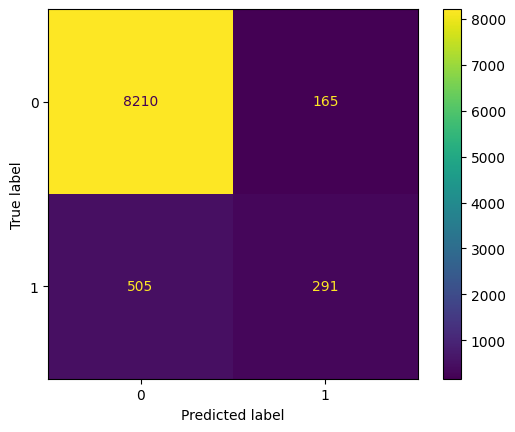

In [38]:

predicted= xgb_model.predict(X_val)

conf_mat = confusion_matrix(y_val, predicted)

disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()


We see that the FN number is quite high, higher than we would like, so we implement measures to reduce this, we penalize false negatives more using the scale_pos_weight param

In [21]:
xgb_model_fn = xgb.XGBClassifier(objective="binary:logistic", n_estimators=5000, booster='gbtree', scale_pos_weight=10.5, eval_metric=['logloss', 'auc'], early_stopping_rounds=50)

In [22]:

eval_set=[(X_val, y_val)]
xgb_model_fn.fit(
    oversampled_X, oversampled_Y,
    eval_set=eval_set,
    verbose=True
)

[0]	validation_0-logloss:0.71100	validation_0-auc:0.78880
[1]	validation_0-logloss:0.73580	validation_0-auc:0.80543
[2]	validation_0-logloss:0.74958	validation_0-auc:0.82070
[3]	validation_0-logloss:0.75379	validation_0-auc:0.83044
[4]	validation_0-logloss:0.73918	validation_0-auc:0.83942
[5]	validation_0-logloss:0.74670	validation_0-auc:0.84461
[6]	validation_0-logloss:0.72413	validation_0-auc:0.84744
[7]	validation_0-logloss:0.70218	validation_0-auc:0.85136
[8]	validation_0-logloss:0.68267	validation_0-auc:0.85589
[9]	validation_0-logloss:0.66499	validation_0-auc:0.85955
[10]	validation_0-logloss:0.64248	validation_0-auc:0.86239
[11]	validation_0-logloss:0.62609	validation_0-auc:0.86215
[12]	validation_0-logloss:0.60446	validation_0-auc:0.86348
[13]	validation_0-logloss:0.58664	validation_0-auc:0.86602
[14]	validation_0-logloss:0.57274	validation_0-auc:0.86717
[15]	validation_0-logloss:0.55225	validation_0-auc:0.86886
[16]	validation_0-logloss:0.54145	validation_0-auc:0.86932
[17]	va

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=['logloss', 'auc'],
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=5000, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

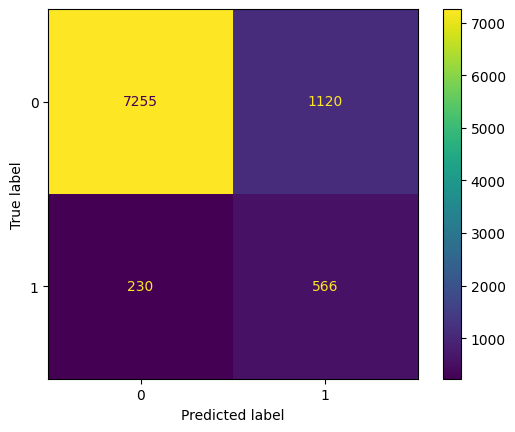

In [23]:
predicted_fn= xgb_model_fn.predict(X_val)

conf_mat_fn = confusion_matrix(y_val, predicted_fn)

disp = ConfusionMatrixDisplay(conf_mat_fn)
disp.plot()

We see that the FN number is less than before although the metrics for this model are a bit worse 

In [2]:
from sklearn.metrics import roc_curve
y_pred_fn = xgb_model_fn.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_fn)

NameError: name 'xgb_model_fn' is not defined

In [47]:
gmeans = np.sqrt(tpr * (1-fpr))

In [48]:
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.301735, G-Mean=0.804


In [1]:
thresholds

NameError: name 'thresholds' is not defined

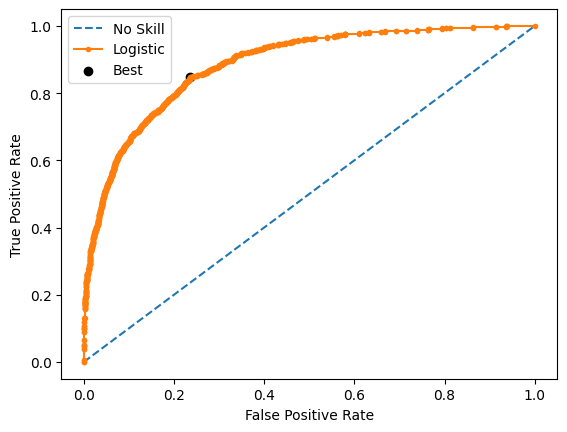

In [49]:
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [51]:
threshold = thresholds[ix]
y_hat = np.where(y_pred_fn > threshold, 1, 0)


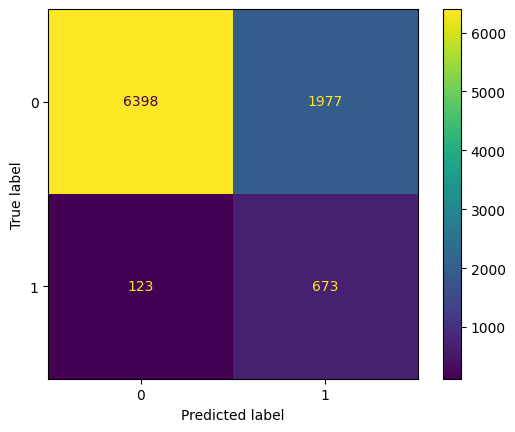

In [52]:
conf_mat = confusion_matrix(y_val, y_hat)

disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()